<a href="https://colab.research.google.com/github/hyunicecream/Natural-Language-Processing-NLP-/blob/main/7_14_%EC%88%98(qqp(maLSTM)).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 31, 16)       1226080     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 31, 16)       0           embedding[0][0]              

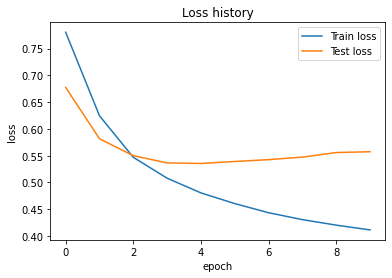


Accuracy = 73.14 %
* ROC AUC score = 0.82


In [ ]:
# -*- coding: utf-8 -*-
"""5-5.qqp(maLSTM).ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1fZAen87b6Yq2ihwMiYVpydrQs1_PoFOF
"""

# Quora question pairs : maLSTM 텍스트 유사도 모델
# -----------------------------------------------
import numpy as np
from sklearn.model_selection  import train_test_split
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import pickle

# Commented out IPython magic to ensure Python compatibility.
# %cd '/content/drive/My Drive/Colab Notebooks'

# 학습 데이터를 읽어온다.
with open('/content/drive/MyDrive/머신러닝/qqp.pkl', 'rb') as f:
    q1_data, q2_data, labels, word2idx = pickle.load(f)

# 학습 데이터와 시험 데이터로 나눈다.
trainQ1, testQ1, trainQ2, testQ2, trainY, testY = train_test_split(q1_data, q2_data, labels, test_size=0.2)

# maLSTM 모델을 빌드한다.
VOCAB_SIZE = np.max([q1_data, q2_data]) + 1
EMB_SIZE = 16
HIDDEN_DIM = 10
FEATURE_DIM = 10
REGULARIZER = 0.005

# Question-1, 2 입력용
K.clear_session()
inputQ1 = Input(batch_shape=(None, trainQ1.shape[1]))
inputQ2 = Input(batch_shape=(None, trainQ2.shape[1]))

# shared embedding
sharedEmb = Embedding(VOCAB_SIZE, EMB_SIZE)

# Question-1 처리용 LSTM
embQ1 = sharedEmb(inputQ1)
embQ1 = Dropout(rate=0.2)(embQ1)
lstmQ1 = LSTM(HIDDEN_DIM)(embQ1)
lstmQ1 = Dense(FEATURE_DIM, activation='relu', 
               kernel_regularizer=regularizers.l2(REGULARIZER))(lstmQ1)
lstmQ1 = Dropout(rate=0.2)(lstmQ1)

# Question-2 처리용 LSTM
embQ2 = sharedEmb(inputQ2)
embQ2 = Dropout(rate=0.2)(embQ2)
lstmQ2 = LSTM(HIDDEN_DIM)(embQ2)
lstmQ2 = Dense(FEATURE_DIM, activation='relu', 
               kernel_regularizer=regularizers.l2(REGULARIZER))(lstmQ2)
lstmQ2 = Dropout(rate=0.2)(lstmQ2)

# Question-1, 2의 출력으로 맨하탄 거리를 측정한다.
# lstmQ1 = lstmQ2 --> mDist = 1
# lstmQ1 - lstmQ2 = inf --> mDist = 0
# mDist = 0 ~ 1 사잇값이므로, trainY = [0, 1]과 mse를 측정할 수 있다.
mDist = K.exp(-K.sum(K.abs(lstmQ1 - lstmQ2), axis=1, keepdims=True))

model = Model([inputQ1, inputQ2], mDist)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005))
model.summary()

# 학습
trainY = trainY.reshape(-1, 1)
testY = testY.reshape(-1, 1)
hist = model.fit([trainQ1, trainQ2], trainY,
                 validation_data = ([testQ1, testQ2], testY),
                 batch_size = 1000, epochs = 10)

# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 시험 데이터로 학습 성능을 평가한다
pred = model.predict([testQ1, testQ2])
predY = np.where(pred > 0.5, 1, 0)
accuracy = (testY == predY).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))
print("* ROC AUC score = %.2f" % (roc_auc_score(testY, pred)))